# Setup

In [3]:
LOG_PLOT = False

In [4]:
%matplotlib notebook
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import os
from helper import *
df = ecdc()
df_at = at()
def country_name(geoId):
    return df[df.geoId==geoId].iloc[0].countriesAndTerritories.replace('_', ' ')

print(df.columns)

Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],
      dtype='object')


## ECDC Data

In [5]:


def plot_selection(selection, roll_days=7, log=False):   
    f,ax = plt.subplots()
    ax.plot(selection.dateRep, selection['cases'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
#     ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))

    plt.xticks(rotation=45)
    ax.bar(selection.dateRep, selection['cases'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    if log:
        plt.yscale('log')
        
    plt.title(selection.iloc[0].countriesAndTerritories.replace('_', ' '))
    plt.tight_layout()

    return f

def plot_comparison(geoIds, roll_days=1, 
                    field='Cumulative_number_for_14_days_of_COVID-19_cases_per_100000',
                    log=False, ndays=30):
    f,ax = plt.subplots(figsize=(9,6))
    for geoId in geoIds:
        selection = select_country(geoId, ndays)
        ax.plot(selection.dateRep, selection[field], 
                label=country_name(geoId))

    ax.xaxis.set_major_locator(plt.MaxNLocator(25))
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))

    plt.xticks(rotation=45)
    if log:
        plt.yscale('log')
        
    plt.legend(loc='best')
    plt.title('Cumulative number for 14 days of COVID-19 cases per 100000')
    plt.tight_layout()

def select_country(geoId, ndays=0):
    if not ndays:
        selection = df[df.geoId==geoId].sort_values(by=['year','month','day'], ascending=True)
    else:
        selection = df[df.geoId==geoId].sort_values(by=['year','month','day'], ascending=True).tail(ndays)
        
    return selection

def plot_country(geoId, **kwargs):
    return plot_selection(select_country(geoId), **kwargs)
    


## DF Subsets

In [22]:
EU = df[df.continentExp=='Europe']
AMERICA = df[(df.continentExp=='America')]


# Overview

## Austria, USA, India, ...

<IPython.core.display.Javascript object>


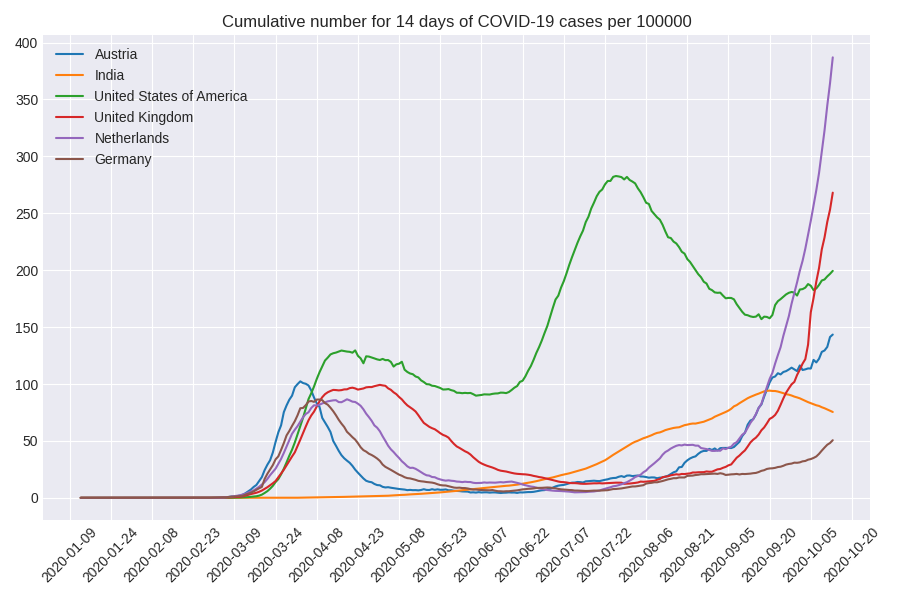

cases                                     \
                         rolling_avg                        last_5_days   
countriesAndTerritories                                                   
India                          70114  70496, 73272, 74383, 66732, 55342   
United_States_of_America       49378  56800, 58082, 54271, 43597, 41653   
United_Kingdom                 14588  17540, 13864, 15165, 12872, 13972   
Netherlands                     5853       5813, 5959, 6493, 6368, 6844   
Germany                         3742       4516, 4721, 3483, 2467, 4122   
Austria                          958         1221, 1181, 901, 1298, 608   

                                 deaths                              \
                            max     sum last_7_days_sum rolling_avg   
countriesAndTerritories                                               
India                     97894  109856            6287         898   
United_States_of_America  78427  215085            4893         699   
United_Kingdom            22961   42875             506          72   
Netherlands                6844    6587             135          19   
Germany                    6294    9634              88          13   
Austria                    1298     869              51           7   

                                                          \
                                       last_5_days   max   
countriesAndTerritories                                    
India                      964, 926, 918, 816, 706  2003   
United_States_of_America  972, 1014, 590, 394, 314  4928   
United_Kingdom                  77, 87, 81, 65, 50  1224   
Netherlands                     13, 13, 23, 17, 12   234   
Germany                          11, 15, 11, 6, 13   315   
Austria                              9, 4, 1, 6, 5    31   

                         Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                             latest   
countriesAndTerritories                                                               
India                                                             75.422688           
United_States_of_America                                         199.399257           
United_Kingdom                                                   268.091136           
Netherlands                                                      386.959665           
Germany                                                           50.629244           
Austria                                                          143.428409           

                                      
                                 max  
countriesAndTerritories               
India                      94.173835  
United_States_of_America  282.723242  
United_Kingdom            268.091136  
Netherlands               386.959665  
Germany                    86.358323  
Austria                   143.428409

In [23]:
# countries = ['AT', 'IN', 'US', 'UK', 'DE', 'NL', 'FR',  'IT', 'ES','EL' ]
countries = ('AT', 'IN', 'US', 'UK', 'NL', 'DE')
SELECTION =  df[df.geoId.isin(countries)]

plot_comparison(countries, log=False, ndays=500)
overview(SELECTION, compact=False)

## Sweden and the world

<IPython.core.display.Javascript object>


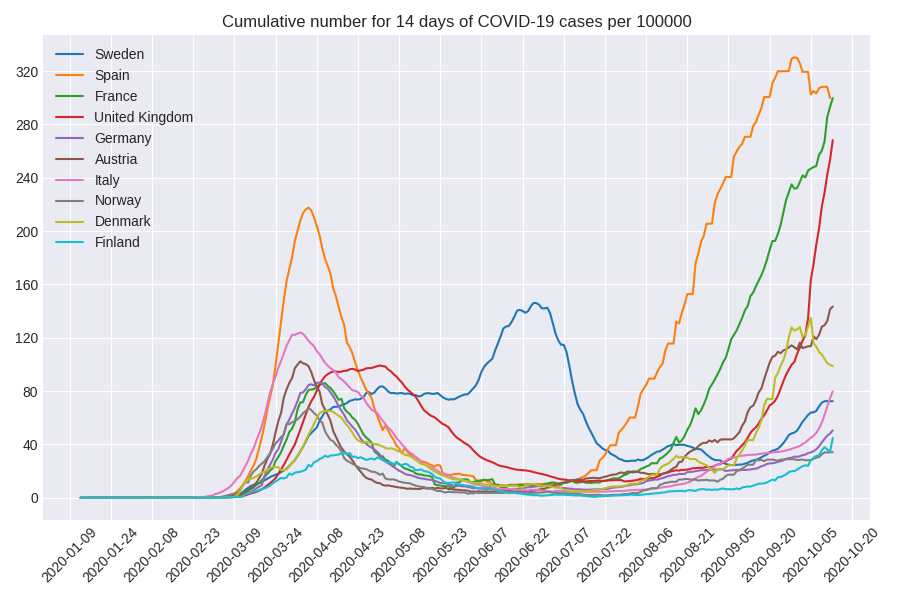

In [15]:
countries = ('SE', 'ES','FR','UK','DE','AT','IT','NO','DK','FI')
plot_comparison(countries, log=False, ndays=500)


## Most cases in the last 7 days

### Europe

In [18]:
overview(EU, compact=False).head(5)

cases                                            \
                        rolling_avg                        last_5_days    max   
countriesAndTerritories                                                         
France                        17029   18129, 20339, 26896, 16101, 8505  26896   
United_Kingdom                14588  17540, 13864, 15165, 12872, 13972  22961   
Russia                        12346  11493, 12126, 12846, 13634, 13592  13634   
Spain                         10794          12423, 12788, 0, 0, 27856  31785   
Netherlands                    5853       5813, 5959, 6493, 6368, 6844   6844   

                        deaths                              \
                           sum last_7_days_sum rolling_avg   
countriesAndTerritories                                      
France                   32825             526          75   
United_Kingdom           42875             506          72   
Russia                   22722            1247         178   
Spain                    33124             899         128   
Netherlands               6587             135          19   

                                                        \
                                     last_5_days   max   
countriesAndTerritories                                  
France                       76, 109, 54, 46, 95  2004   
United_Kingdom                77, 87, 81, 65, 50  1224   
Russia                   191, 201, 197, 143, 125   312   
Spain                        126, 241, 0, 0, 195  1179   
Netherlands                   13, 13, 23, 17, 12   234   

                        Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                            latest   
countriesAndTerritories                                                              
France                                                          299.703566           
United_Kingdom                                                  268.091136           
Russia                                                          104.705994           
Spain                                                           299.767391           
Netherlands                                                     386.959665           

                                     
                                max  
countriesAndTerritories              
France                   299.703566  
United_Kingdom           268.091136  
Russia                   104.705994  
Spain                    330.240113  
Netherlands              386.959665

### World

In [20]:
overview(df, compact=True).head(5)

cases                deaths                  \
                         rolling_avg latest    max     sum last_7_days_sum   
countriesAndTerritories                                                      
India                          70114  55342  97894  109856            6287   
United_States_of_America       49378  41653  78427  215085            4893   
Brazil                         25168   8426  69074  150689            4014   
France                         17029   8505  26896   32825             526   
United_Kingdom                 14588  13972  22961   42875             506   

                                                   
                         rolling_avg latest   max  
countriesAndTerritories                            
India                            898    706  2003  
United_States_of_America         699    314  4928  
Brazil                           573    201  1595  
France                            75     95  2004  
United_Kingdom                    72     50  1224

# Austria
Compare ECDC data with Gesundheitsminesterium Data

## Plots

<IPython.core.display.Javascript object>


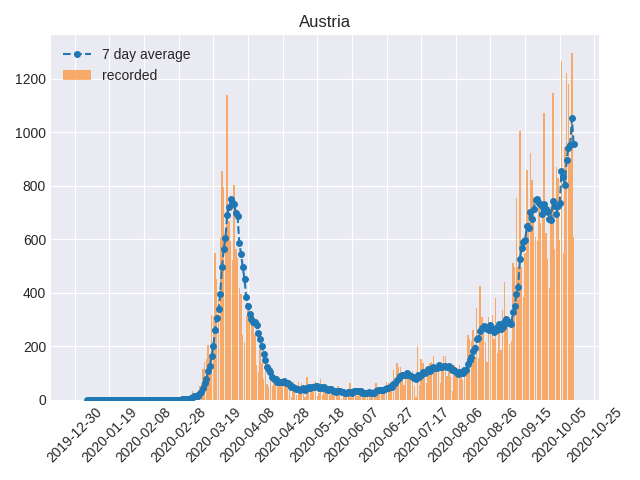

In [21]:
plot_country('AT', log=LOG_PLOT);

# India

<IPython.core.display.Javascript object>


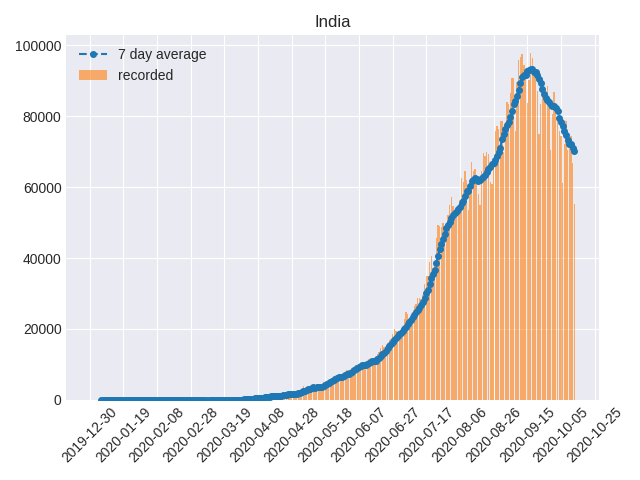

In [24]:
plot_country('IN', log=LOG_PLOT);

# USA

<IPython.core.display.Javascript object>


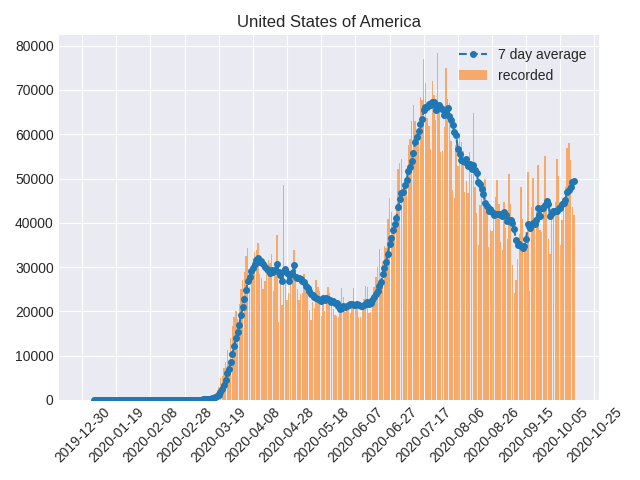

In [25]:
plot_country('US', log=LOG_PLOT);


# Germany

<IPython.core.display.Javascript object>


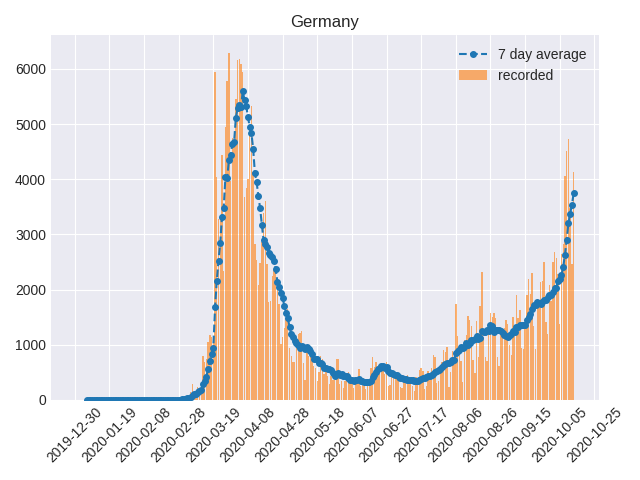

In [26]:
plot_country('DE', log=LOG_PLOT);

## UK

<IPython.core.display.Javascript object>


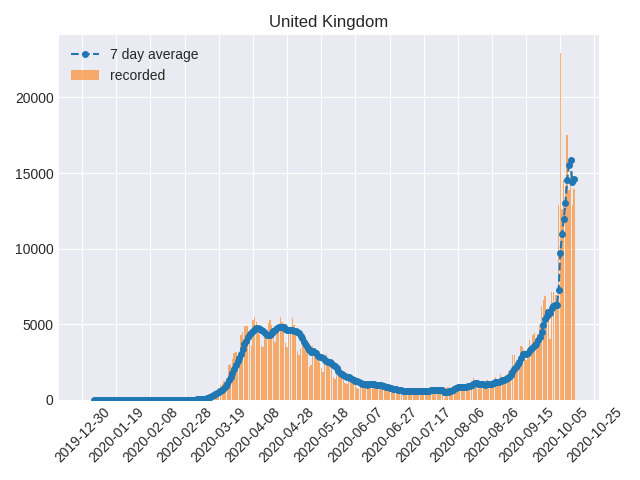

In [27]:
plot_country('UK', log=LOG_PLOT);

# China

<IPython.core.display.Javascript object>


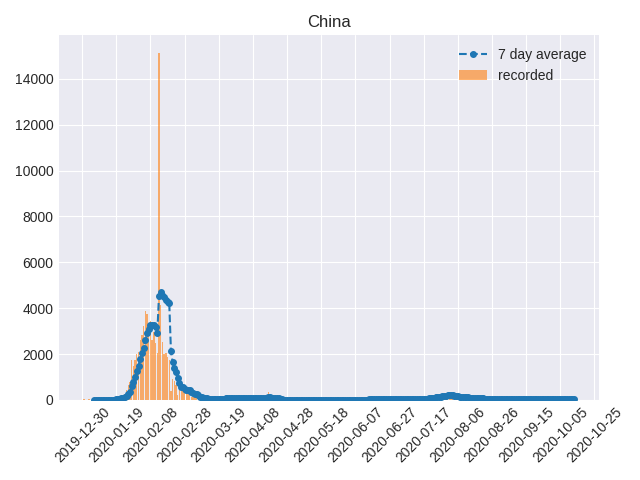

In [28]:
plot_country('CN', log=LOG_PLOT);


# Commit and Push

In [62]:
%cd Documents/code/covid19/
now = datetime.now()
commit_message = "Last run on " + now.strftime('%Y-%m-%d %H:%M')
commit_message
! echo $commit_message > commit_message.txt
! git add .
! git commit -F commit_message.txt
! git push


[Errno 2] No such file or directory: 'Documents/code/covid19/'
/home/gythaogg/Documents/code/covid19/notebooks
[feature/angular 1cd82d8] Last run on 2020-10-11 23:30
 2 files changed, 1162 insertions(+), 1545 deletions(-)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 16 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 177.21 KiB | 2.27 MiB/s, done.
Total 5 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To github.com:gythaogg/covid19.git
   7dae54a..1cd82d8  feature/angular -> feature/angular


In [41]:
! git push --set-upstream origin feature/angular


Branch 'feature/angular' set up to track remote branch 'feature/angular' from 'origin'.
Everything up-to-date
